## Miniproject 2: MovieLens Visualization



### Download data

In [1]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y))

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [15]:
M = max(data["User ID"]) # number of users
N = max(data["Movie ID"]) # number of movies

K = 20

reg = 0.1
eta = 0.03 # learning rate

U,V,err = train_model(M, N, K, eta, reg, train.to_numpy())
test_err = get_err(U, V, test.to_numpy())
print("Test error " + str(test_err))

Epoch 1, E_in (regularized MSE): 0.5105440788359249
Epoch 2, E_in (regularized MSE): 0.4315459341798484
Epoch 3, E_in (regularized MSE): 0.40583235693985464
Epoch 4, E_in (regularized MSE): 0.39302392578450734
Epoch 5, E_in (regularized MSE): 0.37775898307591094
Epoch 6, E_in (regularized MSE): 0.36724222757551267
Epoch 7, E_in (regularized MSE): 0.35731478013538887
Epoch 8, E_in (regularized MSE): 0.3518161121596453
Epoch 9, E_in (regularized MSE): 0.3457462805892067
Epoch 10, E_in (regularized MSE): 0.3377280190699412
Epoch 11, E_in (regularized MSE): 0.33033636280353695
Epoch 12, E_in (regularized MSE): 0.32471565697189947
Epoch 13, E_in (regularized MSE): 0.3229163192151422
Epoch 14, E_in (regularized MSE): 0.3191508362971972
Epoch 15, E_in (regularized MSE): 0.3130231288125017
Epoch 16, E_in (regularized MSE): 0.3105604742561971
Epoch 17, E_in (regularized MSE): 0.3098833069044369
Epoch 18, E_in (regularized MSE): 0.3046880278401759
Epoch 19, E_in (regularized MSE): 0.303469570063

In [36]:
A, _, _ = np.linalg.svd(V)
A1 = (A[:,:2]).T
print(A1.shape)
print(U.shape)
print(V.shape)
Ut = np.matmul(A1, U.T)
Vt = np.matmul(A1, V)
print(Vt.shape)

(2, 20)
(943, 20)
(20, 1682)
(2, 1682)


In [89]:
most_popular = np.asarray(data['Movie ID'].value_counts()[:10].tolist())
most_popular_labels = movies.loc[movies['Movie ID'].isin(most_popular)]["Movie Title"]
print(most_popular)
most_popular_labels = most_popular_labels[most_popular - 1].to_numpy()
most_popular_labels

[583 509 508 507 485 481 478 452 431 429]


array(['Romeo Is Bleeding (1993)', 'My Left Foot (1989)',
       'People vs. Larry Flynt, The (1996)',
       'Streetcar Named Desire, A (1951)', 'My Fair Lady (1964)',
       'Apartment, The (1960)', 'Philadelphia Story, The (1940)',
       'Jaws 2 (1978)', 'Highlander (1986)',
       'Day the Earth Stood Still, The (1951)'], dtype=object)

In [90]:
condensed = data.groupby('Movie ID', as_index=False, sort=False)['Rating'].mean()
best = np.asarray(condensed.nlargest(10, 'Rating')["Movie ID"].tolist())
best_labels = movies.loc[movies['Movie ID'].isin(best)]["Movie Title"]
print(best)
best_labels = best_labels[best - 1].to_numpy()
print(best_labels)

[1189 1500  814 1536 1293 1599 1653 1467 1122 1201]
['Prefontaine (1997)' 'Santa with Muscles (1996)'
 'Great Day in Harlem, A (1994)' 'Aiqing wansui (1994)' 'Star Kid (1997)'
 "Someone Else's America (1995)"
 'Entertaining Angels: The Dorothy Day Story (1996)'
 'Saint of Fort Washington, The (1993)' 'They Made Me a Criminal (1939)'
 'Marlene Dietrich: Shadow and Light (1996) ']


          x         y                                   name
0  1.717592 -0.398762               Romeo Is Bleeding (1993)
1  2.034586 -0.463011                    My Left Foot (1989)
2  2.076717 -0.408176     People vs. Larry Flynt, The (1996)
3  2.150376 -0.465499       Streetcar Named Desire, A (1951)
4  2.024346  0.169960                    My Fair Lady (1964)
5  2.154359 -0.435882                  Apartment, The (1960)
6  2.089734 -0.131362         Philadelphia Story, The (1940)
7  1.351837  0.641078                          Jaws 2 (1978)
8  1.914441  0.425232                      Highlander (1986)
9  2.057106  0.040354  Day the Earth Stood Still, The (1951)


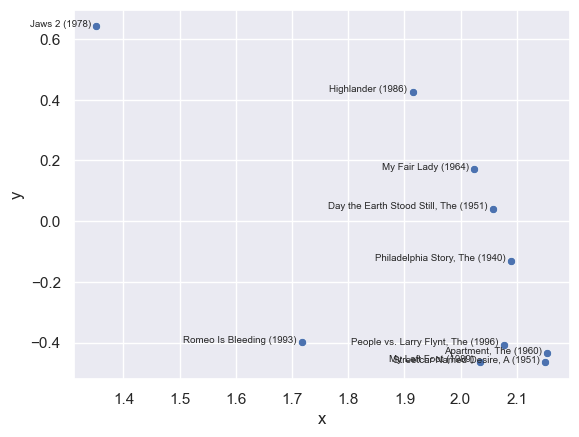

In [99]:
most_popular_data = pd.DataFrame(Vt[:,most_popular-1].T, columns=['x', 'y'])
most_popular_data.insert(2, 'name', most_popular_labels, True)
print(most_popular_data)
sns.scatterplot(data=most_popular_data, x='x', y='y')

for i in range(len(most_popular_data)):
    plt.text(most_popular_data['x'][i] - 0.01, most_popular_data['y'][i], \
             most_popular_data['name'][i], fontsize=7, ha='right')

          x         y                                               name
0  2.220882  0.219087                                 Prefontaine (1997)
1  2.400341 -0.163488                          Santa with Muscles (1996)
2  1.779300 -0.138630                      Great Day in Harlem, A (1994)
3  1.770415 -0.635349                               Aiqing wansui (1994)
4  1.985163  1.040355                                    Star Kid (1997)
5  2.255129  0.218538                      Someone Else's America (1995)
6  1.340384 -0.349803  Entertaining Angels: The Dorothy Day Story (1996)
7  2.450886  0.408538               Saint of Fort Washington, The (1993)
8  2.033790 -0.396160                     They Made Me a Criminal (1939)
9  1.913624 -0.851824         Marlene Dietrich: Shadow and Light (1996) 


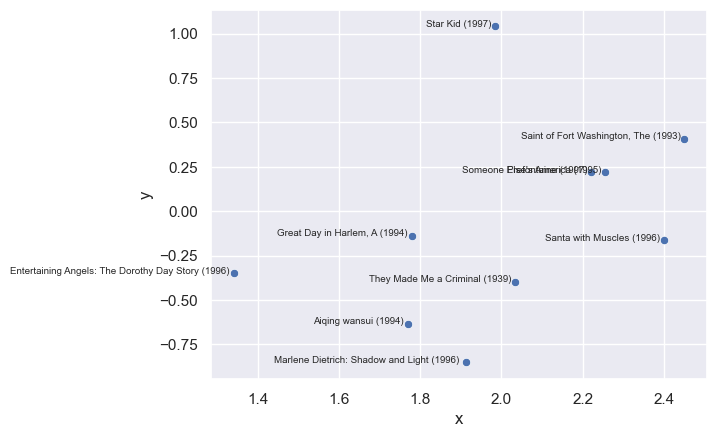

In [101]:
best_data = pd.DataFrame(Vt[:,best-1].T, columns=['x', 'y'])
best_data.insert(2, 'name', best_labels, True)
print(best_data)
sns.scatterplot(data=best_data, x='x', y='y')

for i in range(len(best_data)):
    plt.text(best_data['x'][i] - 0.01, best_data['y'][i], \
             best_data['name'][i], fontsize=7, ha='right')